# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import math

In [2]:
%matplotlib inline

# Raw data

In [3]:
data0 = pd.read_csv('listings.csv')

In [4]:
# list of all variables
data0.columns.values

array(['id', 'scrape_id', 'last_scraped', 'name', 'picture_url', 'host_id',
       'host_name', 'host_since', 'host_picture_url', 'street',
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet', 'price',
       'weekly_price', 'monthly_price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'host_listing_count'], dtype=object)

In [5]:
nrow = len(data0.index)
nrow

27392

# Select relevant variables

In [6]:
data = data0[['name', 'neighbourhood_cleansed', 'city', 'zipcode', 'latitude', 'longitude', 'is_location_exact',
          'property_type', 'room_type', 'accommodates','bathrooms', 'bedrooms', 'beds', 'square_feet', 'price',
           'weekly_price', 'monthly_price', 'review_scores_value']]

In [7]:
data.head(2)

,name,neighbourhood_cleansed,city,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,weekly_price,monthly_price,review_scores_value
0,Stay like a real New Yorker!,Midtown East,New York,10022,40.756852,-73.964754,t,Apartment,Entire home/apt,2,1,1,1,NaN,$160.00,"$1,000.00",NaN,9
1,Apartment 20 Minutes Times Square,Hamilton Heights,New York,NaN,40.830599,-73.941014,f,Apartment,Entire home/apt,10,1,3,3,NaN,$105.00,NaN,NaN,8


# Cleaning data

## Prices : convert into right format, replace missing values

In [8]:
day_price = []
for i in range(nrow):
    # remove commas ans $ sign, convert into float
    day_price.append((float(data.price[i].replace(',','')[1:])))

    
# there are null values for weekly / monthly prices
# use daily price to fill missing values

week_price, month_price = [], []    
for i in range(nrow):
    if pd.isnull(data.weekly_price[i]) == True :
        week_price.append(7*day_price[i])
    else :
        week_price.append(float(data.weekly_price[i].replace(',','')[1:]))
        
for i in range(nrow):
    if pd.isnull(data.monthly_price[i]) == True :
        month_price.append(30*day_price[i])
    else :
        month_price.append(float(data.monthly_price[i].replace(',','')[1:]))

In [9]:
data = data.drop(['price', 'weekly_price', 'monthly_price'], axis = 1)

In [10]:
data['day_price'] = day_price
data['week_price'] = week_price
data['month_price'] = month_price

## New variable : monthly price per square foot

In [11]:
price_sqft = []
for i in range(nrow):
    if pd.isnull(data.square_feet[i]) == False and data.square_feet[i] != 0:
        price_sqft.append(round(data.month_price[i]/data.square_feet[i], 2))
    else :
        price_sqft.append(None)

In [12]:
data['price_sqft'] = price_sqft

## Aggregate neighbourhoods

In [13]:
len(set(data.neighbourhood_cleansed)) 
# 186 different values with duplicates sometimes

186

There are too many different names of neighborhoods. Sometimes, two names represent the same district. We rename them using the zipcodes. This website gives the correspondence between zipcodes, districts and neighborhoods. https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm

We verify that there are not many missing values in the zipcode column less than 1%

In [14]:
# list of indices where zipcode is missing
non_missing_zip = [ind for ind in range(nrow) if pd.isnull(data.zipcode)[ind] == False] 
# get the proportion
len(non_missing_zip)/nrow 
# returns 0.994

0.9940858644859814

We can remove these missing values

In [15]:
data = data.ix[non_missing_zip,]
# reset indices
data = data.reset_index()

In [16]:
# update new number rows
nrow = len(data.index)

### Change city column

In [17]:
manhattan_zip = ['10026' , '10027' , '10030' , '10037' , '10039' , 
                 '10001' , '10011' , '10018' , '10019' , '10020' , '10036' , 
                 '10029' , '10035' , 
                 '10010' , '10016' , '10017' , '10022' , 
                 '10012' , '10013' , '10014' , 
                 '10004' , '10005' , '10006' , '10007' , '10038' , '10280' , 
                 '10002' , '10003' , '10009' , 
                 '10021' , '10028' , '10044' , '10065' , '10075' , '10128' , 
                 '10023' , '10024' , '10025' , 
                 '10031' , '10032' , '10033' , '10034' , '10040']

In [18]:
brooklyn_zip = ['11212','11213','11216','11233','11238',
                '11209','11214','11228',
                '11204','11218','11219','11230',
                '11234','11236','11239',
                '11223','11224','11229','11235',
                '11201','11205','11215','11217','11231',
                '11203','11210','11225','11226',
                '11207','11208',
                '11211','11222',
                '11220','11232',
                '11206','11221','11237']

#### DO THE SAME FOR QUEENS, BRONX etc

In [19]:
borough = []

for i in range(nrow):
    if data.zipcode[i] in manhattan_zip :
        borough.append("Manhattan")
    elif data.zipcode[i] in brooklyn_zip :
        borough.append("Brooklyn")
    else :
        borough.append("Other")

In [20]:
district = []

for i in range(nrow):
    # Manhattan
    if data.zipcode[i] in ['10026' , '10027' , '10030' , '10037' , '10039']:
        district.append('Central Harlem')
    elif data.zipcode[i] in ['10001' , '10011' , '10018' , '10019' , '10020' , '10036']:
        district.append('Chelsea and Clinton')
    elif data.zipcode[i] in ['10029' , '10035']:
        district.append('East Harlem')
    elif data.zipcode[i] in ['10010' , '10016' , '10017' , '10022'] :
        district.append('Gramercy Park and Murray Hill')
    elif data.zipcode[i] in ['10012' , '10013' , '10014'] :
        district.append('Greenwich Village and Soho')
    elif data.zipcode[i] in ['10004' , '10005' , '10006' , '10007' , '10038' , '10280'] :
        district.append('Lower Manhattan')
    elif data.zipcode[i] in ['10002' , '10003' , '10009'] :
        district.append('Lower East Side')
    elif data.zipcode[i] in ['10021' , '10028' , '10044' , '10065' , '10075' , '10128'] :
        district.append('Upper East Side')
    elif data.zipcode[i] in ['10023' , '10024' , '10025'] :
        district.append('Upper West Side')
    elif data.zipcode[i] in ['10031' , '10032' , '10033' , '10034' , '10040'] :
        district.append('Inwood and Washington Heights')
    
    # Brooklyn, etc
    else :
        district.append('Other')
     

In [21]:
data = data.drop(['city', 'neighbourhood_cleansed'], axis = 1)

In [22]:
data['district'] = district
data['borough'] = borough

#### AT THE MOMENT LET'S WORK ON MANHATTAN ONLY, TOO MANY NEIGHBOURHOODS

In [23]:
df = data.ix[[ind for ind in range(nrow) if data.zipcode[ind] in manhattan_zip],]
df = df.reset_index()

In [24]:
# column names
df.columns.values

array(['level_0', 'index', 'name', 'zipcode', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet',
       'review_scores_value', 'day_price', 'week_price', 'month_price',
       'price_sqft', 'district', 'borough'], dtype=object)

In [25]:
df = df.drop(['level_0','index'], axis = 1)

# Data exploration

Need help on plots ?
- http://matplotlib.org/api/pyplot_api.html
- http://matplotlib.org/examples/pylab_examples/boxplot_demo.html

For colored boxplots these are very good : 
- http://matplotlib.org/gallery.html
- http://matplotlib.org/examples/pylab_examples/boxplot_demo.html

## Continous, categorical variables and coordinates

In [26]:
loc_var = ['latitude', 'longitude']

# categorical variables
categ_var = ['name', 'district', 'borough', 'zipcode', 'is_location_exact', 'property_type', 'room_type']

# continuous 
cont_var = [x for x in df.columns.values if x not in categ_var + loc_var]

To create list comprehensions as above : http://www.secnetix.de/olli/Python/list_comprehensions.hawk

## Summary on continuous variables

In [27]:
df[cont_var].describe()

,accommodates,bathrooms,bedrooms,beds,square_feet,review_scores_value,day_price,week_price,month_price,price_sqft
count,15414.000000,15170.000000,15331.000000,15353.000000,541.000000,10483.000000,15414.000000,15414.000000,15414.000000,507.000000
mean,2.880368,1.099967,1.084404,1.486485,679.314233,9.099017,206.144998,1404.602050,5713.610614,101.102781
std,1.624230,0.334932,0.655290,0.902830,688.384694,0.921826,257.409412,1779.852676,7658.473651,765.465495
min,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,10.000000,70.000000,300.000000,0.470000
25%,2.000000,1.000000,1.000000,1.000000,380.000000,9.000000,105.000000,700.000000,2850.000000,5.360000
50%,2.000000,1.000000,1.000000,1.000000,600.000000,9.000000,155.000000,1050.000000,4350.000000,8.440000
75%,4.000000,1.000000,1.000000,2.000000,850.000000,10.000000,225.000000,1500.000000,6000.000000,12.500000
max,16.000000,6.000000,8.000000,16.000000,12000.000000,10.000000,6950.000000,48650.000000,208500.000000,8250.000000


## Price per day : global analysis

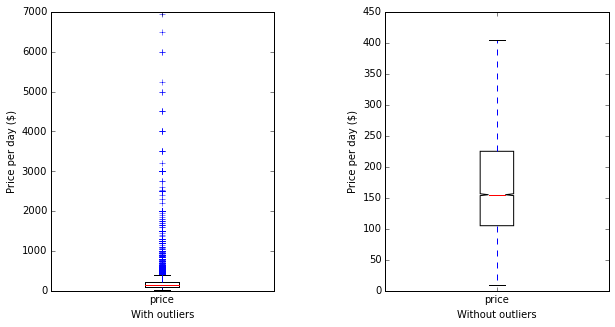

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
fig.subplots_adjust(wspace= 0.5)
# to adjust whitespace between subplots : plt.subplots_adjust(wspace=0.01,hspace=0.01)

# rectangular box plot
bplot1 = axes[0].boxplot(df.day_price, 0, 'b+', patch_artist = True)
# notch shape box plot (notch = 1)
bplot2 = axes[1].boxplot(df.day_price, 1, '',  patch_artist = True)

# adding horizontal grid lines
axes[0].set_xlabel('With outliers')
axes[1].set_xlabel('Without outliers')
for ax in axes:
    ax.set_ylabel('Price per day ($)')

# add x-tick labels
plt.setp(axes, xticks=[1], xticklabels=['price'])

plt.show()


## Price per district

### Example : daily price in Midtown versus Harlem versus Greenwich Village

In [29]:
df_UpperEast = df.ix[[ind for ind in list(df.index) if df.district[ind] == 'Upper East Side'],]
df_EastHarlem = df.ix[[ind for ind in list(df.index) if df.district[ind] == 'East Harlem'],]
df_Greenwich = df.ix[[ind for ind in list(df.index) if df.district[ind] == 'Greenwich Village and Soho'],]

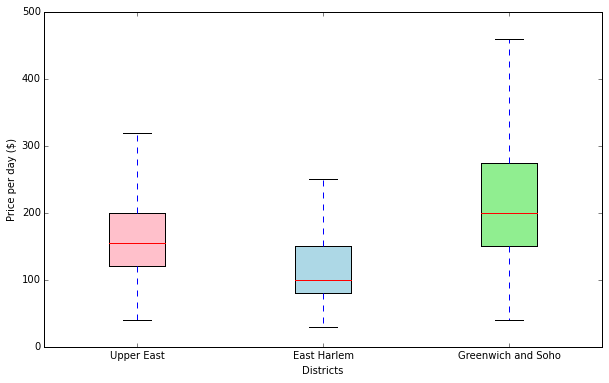

In [30]:
fig, axes = plt.subplots(figsize=(10, 6))
all_data = [df_UpperEast.day_price, df_EastHarlem.day_price, df_Greenwich.day_price]
bplot = plt.boxplot(all_data, 0, '', # to remove outliers
                        vert=True,   # vertical box aligmnent
                        patch_artist=True)   # fill with color
# to display outliers : write instead : 'bD' (blue dots) or 'rD' (red dots) etc.


# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)


# adding horizontal grid lines
#for ax in axes:
    #ax.yaxis.grid(True)
    #ax.set_xticks([y+1 for y in range(len(all_data))], )
axes.set_xlabel('Districts')
axes.set_ylabel('Price per day ($)')

    
# add x-tick labels
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=['Upper East', 'East Harlem', 'Greenwich and Soho'])

plt.show()

### TBD : Daily price in each district

Now we can loop on all districts and get this graphical comparison

## Same analysis for number of bedrooms (global and per district)

## Same analysis for appartment surface (global and per district)

## Number of appartments per district

When you want to show the number of observations in each category :
- https://stanford.edu/~mwaskom/software/seaborn/tutorial/categorical.html

In [31]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

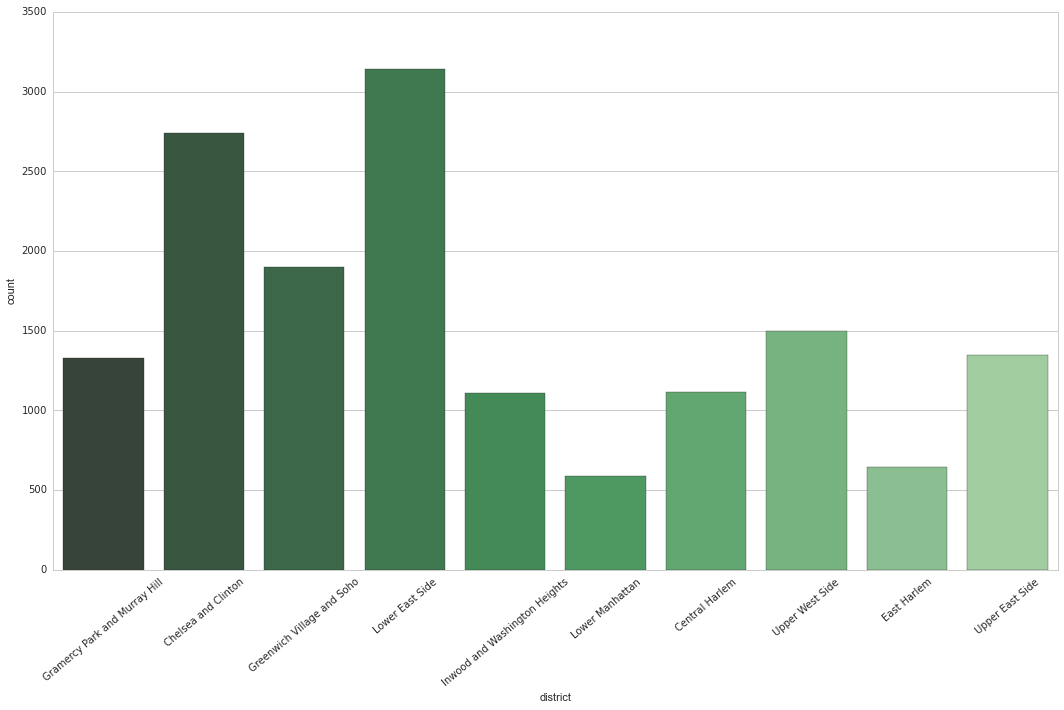

In [32]:
fig, axes = plt.subplots(figsize=(18, 10))

sns.countplot(x="district", data=df, palette="Greens_d")

plt.xticks(rotation=40) 
# how to rotate tickers for seaborn : http://stackoverflow.com/questions/27037241/changing-the-rotation-of-tick-labels-in-seaborn-heatmap

plt.show()